In [58]:
import pandas as pd
import numpy as np
import os
import sys
import gc
from sklearn.manifold import TSNE
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
import scipy 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import utils
reload(utils)

<module 'utils' from '/Users/milk/Desktop/git_repositories/READMISSIONS/washtenaw_case_study/notebooks/utils.py'>

In [2]:
matplotlib.rcParams['figure.dpi'] = 200
plt.style.use('seaborn-deep')

In [3]:
"""
Load all Washtenaw Country Images and features
"""

DATA_PATH = "../cleaned_data/clean_data.csv"
data_df = pd.read_csv(DATA_PATH)
data_df['TRACT'] = data_df['TRACT'].astype(str)
print(data_df.shape)

(5013, 5338)


In [4]:
"""
Load column names
"""
tmp = pd.read_csv("../cleaned_data/population_column_map.csv")
POP_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/income_column_map.csv")
INC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/occuptation_column_map.csv")
OCC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/education_column_map.csv")
EDU_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/income_column_map.csv")
INC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

tmp = pd.read_csv("../cleaned_data/eigenvalue_column_map.csv")
REDS = tmp['Red_Columns'].to_list()
GREENS = tmp['Green_Columns'].to_list()
BLUES = tmp['Blue_Columns'].to_list()

tmp = pd.read_csv("../cleaned_data/google_column_map.csv")
GOOGLE_RED_COLS = [x for x in tmp['r_color_pixel_columns'] if str(x) != 'nan']
GOOGLE_GREEN_COLS = [x for x in tmp['g_color_pixel_columns'] if str(x) != 'nan']
GOOGLE_BLUE_COLS = [x for x in tmp['b_color_pixel_columns'] if str(x) != 'nan']
GOOGLE_COL_SCORE_COLS = [x for x in tmp['color_score_columns'] if str(x) != 'nan']
GOOGLE_COL_FRAC_COLS = [x for x in tmp['color_fraction_columns'] if str(x) != 'nan']
GOOGLE_LABEL_COLS = [x for x in tmp['Label_columns'] if str(x) != 'nan']
GOOGLE_LABEL_SCORE_COLS = [x for x in tmp['Label_score_columns'] if str(x) != 'nan']

MANUAL_LABELS = [x.strip() for x in open("../image_data/manual_labels.txt")]
print(f"Number of Distinct Labels in curated list: {len(MANUAL_LABELS)}")

Number of Distinct Labels in curated list: 99


In [5]:
"""
Load Ann Arbor 500 cities data
"""

CITIES_PATH = "../demographic_data/Ann_Arbor_500_Cities.csv"
cities_df = pd.read_csv(CITIES_PATH)
print(cities_df.shape)
cities_df = cities_df[cities_df['PlaceName'] == 'Ann Arbor']
print(f"Ann Arbor tracts: {cities_df.shape}")
cities_df['TRACT'] = cities_df['TractFIPS'].astype(str).str[-6:]

(27210, 63)
Ann Arbor tracts: (33, 63)


In [6]:
"""
filter the images to Ann Arbor
"""

data_df = data_df[data_df['TRACT'].isin(cities_df['TRACT'])]
print(data_df.shape)

CITIES_COLS = cities_df.columns.to_list()
data_df = pd.merge(data_df, cities_df, on='TRACT', how='left')
print(data_df.shape)

(208, 5338)
(208, 5401)


In [7]:
"""
a list of crude prevalences from 500 cities data
"""

ALL_LABEL_COLS = [x for x in data_df.columns if 'label' in x]
print(f"Number of Distinct Labels: {len(ALL_LABEL_COLS)}")

MANUAL_LABELS = [x.strip() for x in open("../image_data/manual_labels.txt")]
print(f"Number of Distinct Labels in curated list: {len(MANUAL_LABELS)}")

PREVALENCE = [x for x in CITIES_COLS if 'CrudePrev' in x]
print(f"Number prevalence columns: {len(PREVALENCE)}")

REDS = [x for x in data_df.columns if 'red_eig' in x]
BLUES = [x for x in data_df.columns if 'blue_eig' in x]
GREENS = [x for x in data_df.columns if 'green_eig' in x]

Number of Distinct Labels: 326
Number of Distinct Labels in curated list: 99
Number prevalence columns: 28


In [8]:
"""
Need to balance crude prevalance by the population

DP05_0001E is the column
"""
POP_COLUMNS = pd.read_csv("../cleaned_data/population_column_map.csv")
TOTAL_POP_COL = 'DP05_0001E'

NORMED_PREVALANCE_COLS = []

for col in PREVALENCE:
    condition = col.split("_")[0]
    new_col_name = f"{condition}_rate"
    NORMED_PREVALANCE_COLS.append(new_col_name)
    data_df[new_col_name] = data_df[col] / data_df[TOTAL_POP_COL]

print("done.")

done.


No signficant differences in OBESITY_rate for World_label


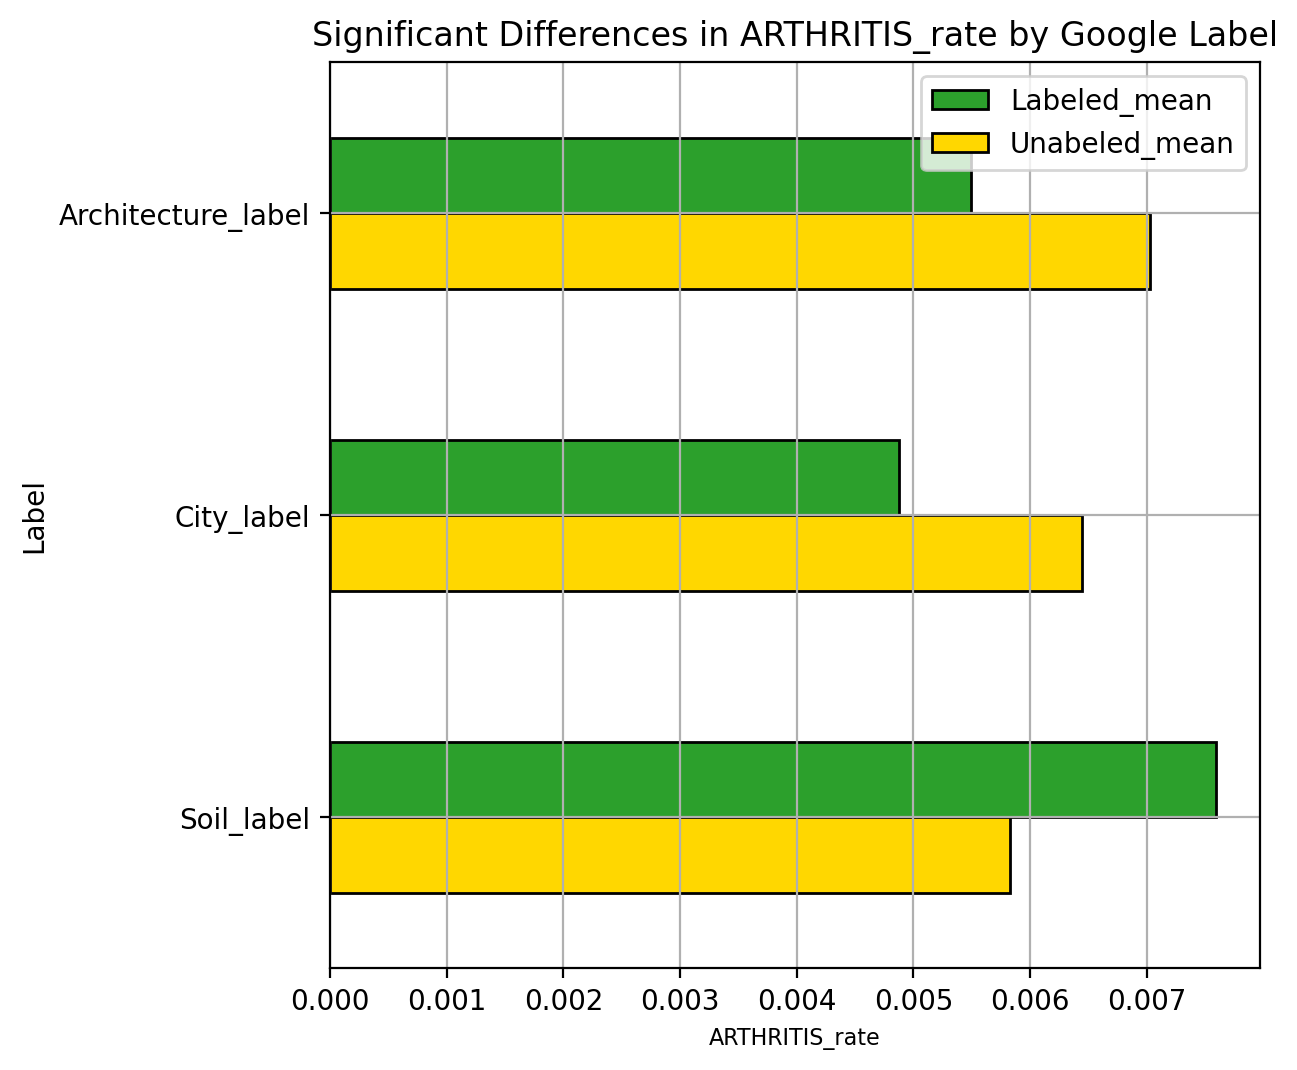

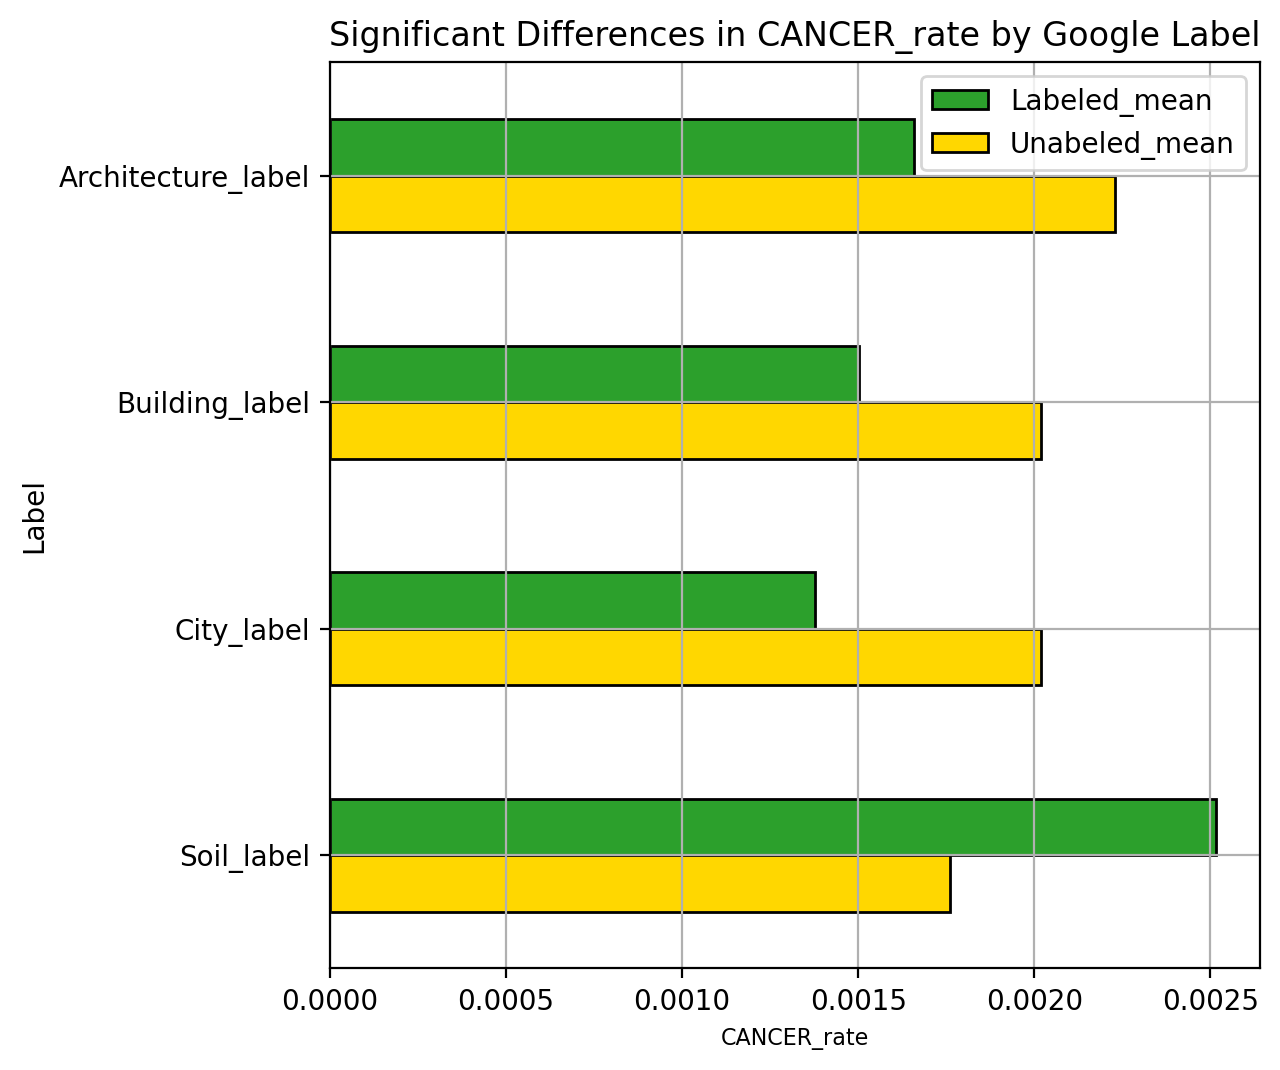

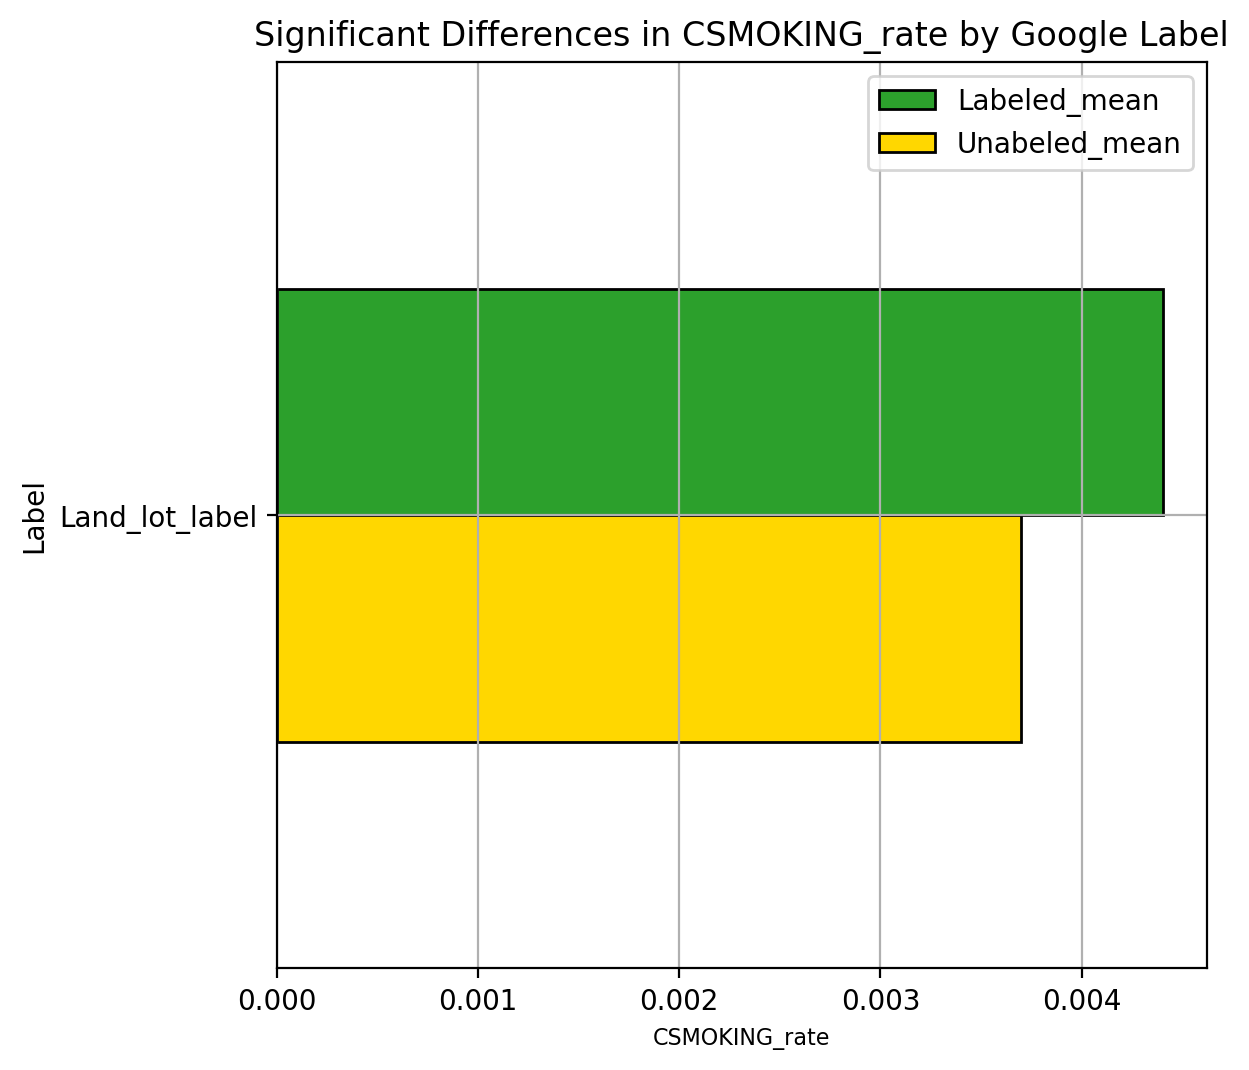

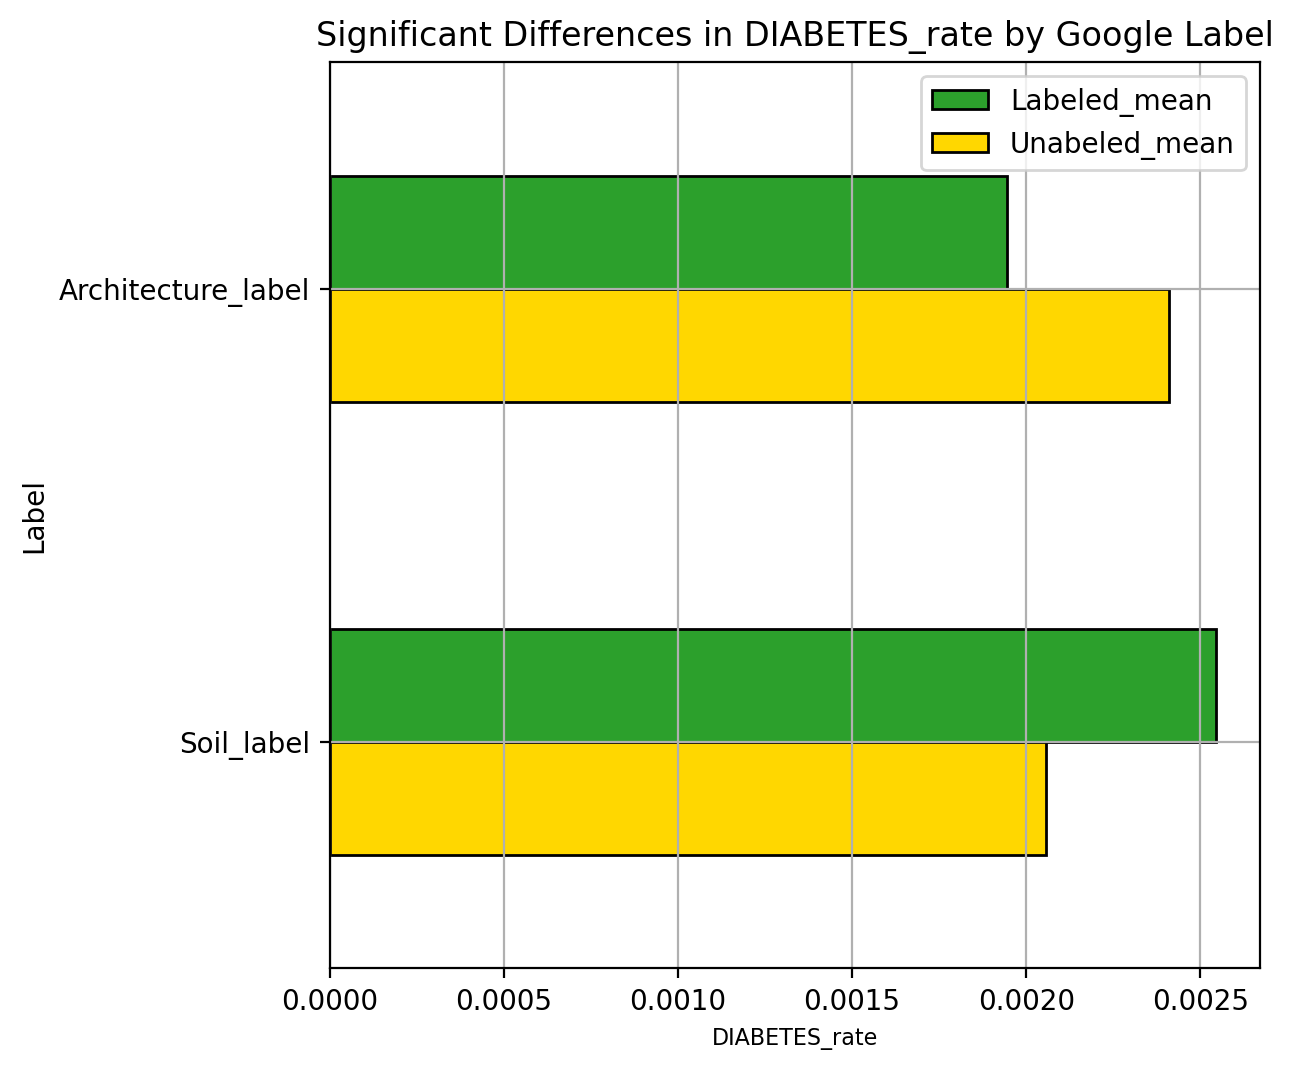

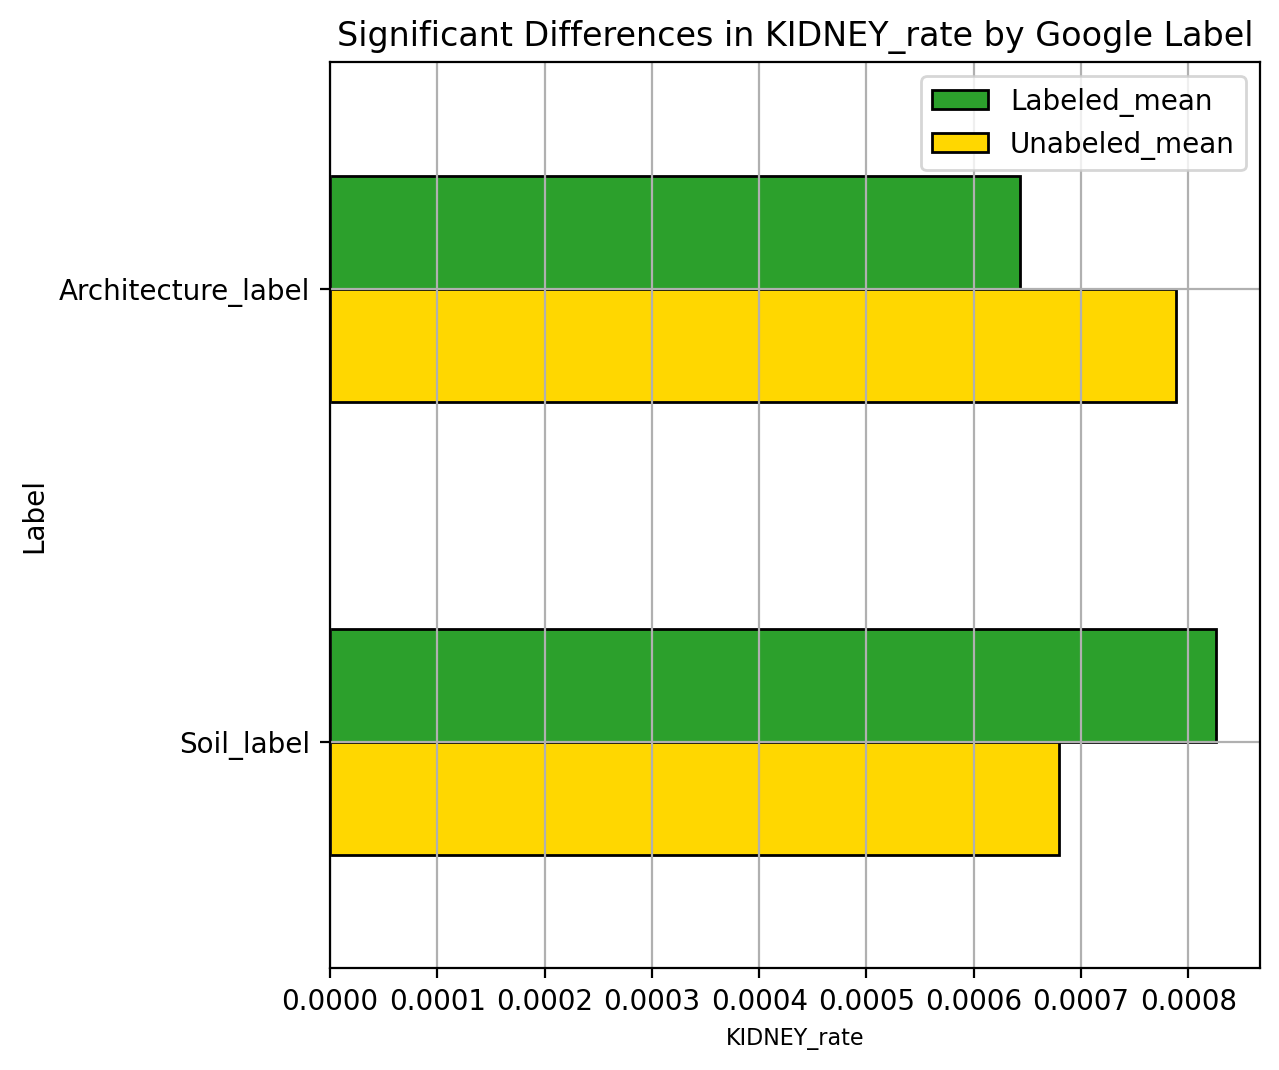

In [9]:
"""
Let's do tttest for each label 
"""

MIN_LABEL_THRESHOLD = int(len(data_df) / 10)
NAN_POLICY = 'omit'
CONDITIONS = ['ARTHRITIS_rate', 'CANCER_rate', 'CSMOKING_rate', 
              'DIABETES_rate', 'KIDNEY_rate', 'OBESITY_rate']


for prev in CONDITIONS:
    TITLE = f'Significant Differences in {prev} by Google Label'
    TARGET_COL = prev
    new_rows = []
    for col in MANUAL_LABELS:

        labeled = data_df[data_df[col] == 1]
        unlabeled = data_df[data_df[col] == 0]

        # skip ttests where label is not on 10% of the images
        if len(labeled) < MIN_LABEL_THRESHOLD:
            continue

        T, pval = scipy.stats.ttest_ind(labeled[TARGET_COL], 
                            unlabeled[TARGET_COL], 
                            nan_policy=NAN_POLICY)

        row = {
            'Label':col,
            'N_labeled':len(labeled),
            'N_unlabeled':len(unlabeled),
            'Labeled_mean':labeled[TARGET_COL].mean(),
            'Unabeled_mean':unlabeled[TARGET_COL].mean(),
            'T-Obs':T,
            'p-Value':pval,
            'Bonferroni_Alpha': 1 - (1 - 0.05)**0.5
        }

        new_rows.append(row)

    res = pd.DataFrame(new_rows)
    res['Reject'] = np.where(res['p-Value'] <= res['Bonferroni_Alpha'], 'True', 'False' )
    # print(res.head())

    sigs = res[res['Reject'] == 'True']

    if len(sigs) == 0:
        print(f"No signficant differences in {TARGET_COL} for {col}")
        continue

    sigs.set_index('Label', inplace=True)
    sigs = sigs[['Labeled_mean', 'Unabeled_mean']]
    sigs.plot(kind='barh', edgecolor='black', figsize=(6, 6), title=TITLE, color=['tab:green', 'gold'])
    plt.grid()
    plt.xlabel(f'{TARGET_COL}', fontsize=8)
    plt.gca().invert_yaxis()
    # save_filepath = f"../figures/{TITLE}.png"
    # plt.savefig(save_filepath,  bbox_inches = 'tight')


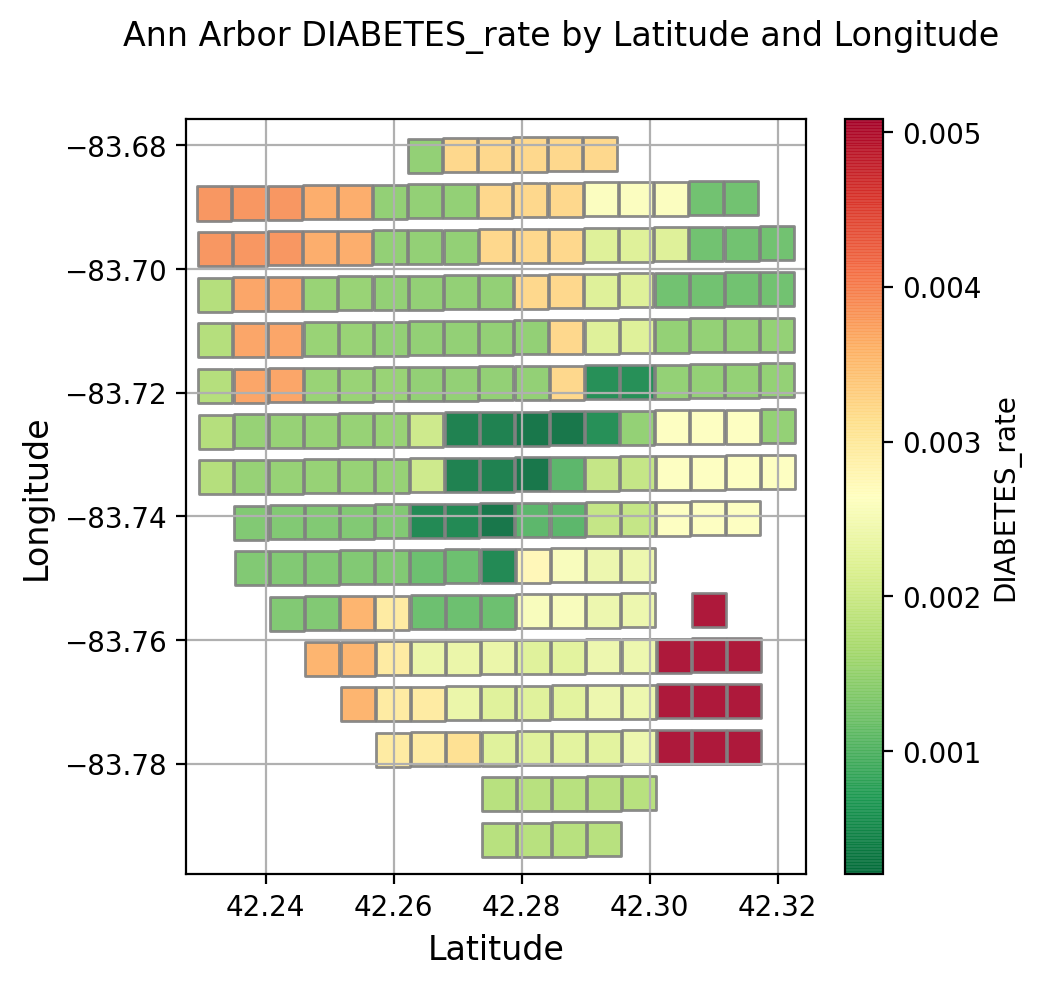

In [10]:
"""
normalized disease rates by latitude and logitude
"""

TARGET_COL = 'DIABETES_rate'
TITLE = f'Ann Arbor {TARGET_COL} by Latitude and Longitude'

fig = utils.build_fig(title=f"{TITLE}",
                      y_lab="Longitude", 
                      x_lab="Latitude")

scat = plt.scatter(data_df['latitiude'], 
                   data_df['longitude'], 
                   s=150, 
                   c=data_df[TARGET_COL],
                   edgecolor='grey',
                   alpha=0.9,
                   marker="s",
                   cmap='RdYlGn_r')

plt.grid()
cb = plt.colorbar(scat)
cb.set_label(f'{TARGET_COL}')
# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')
    

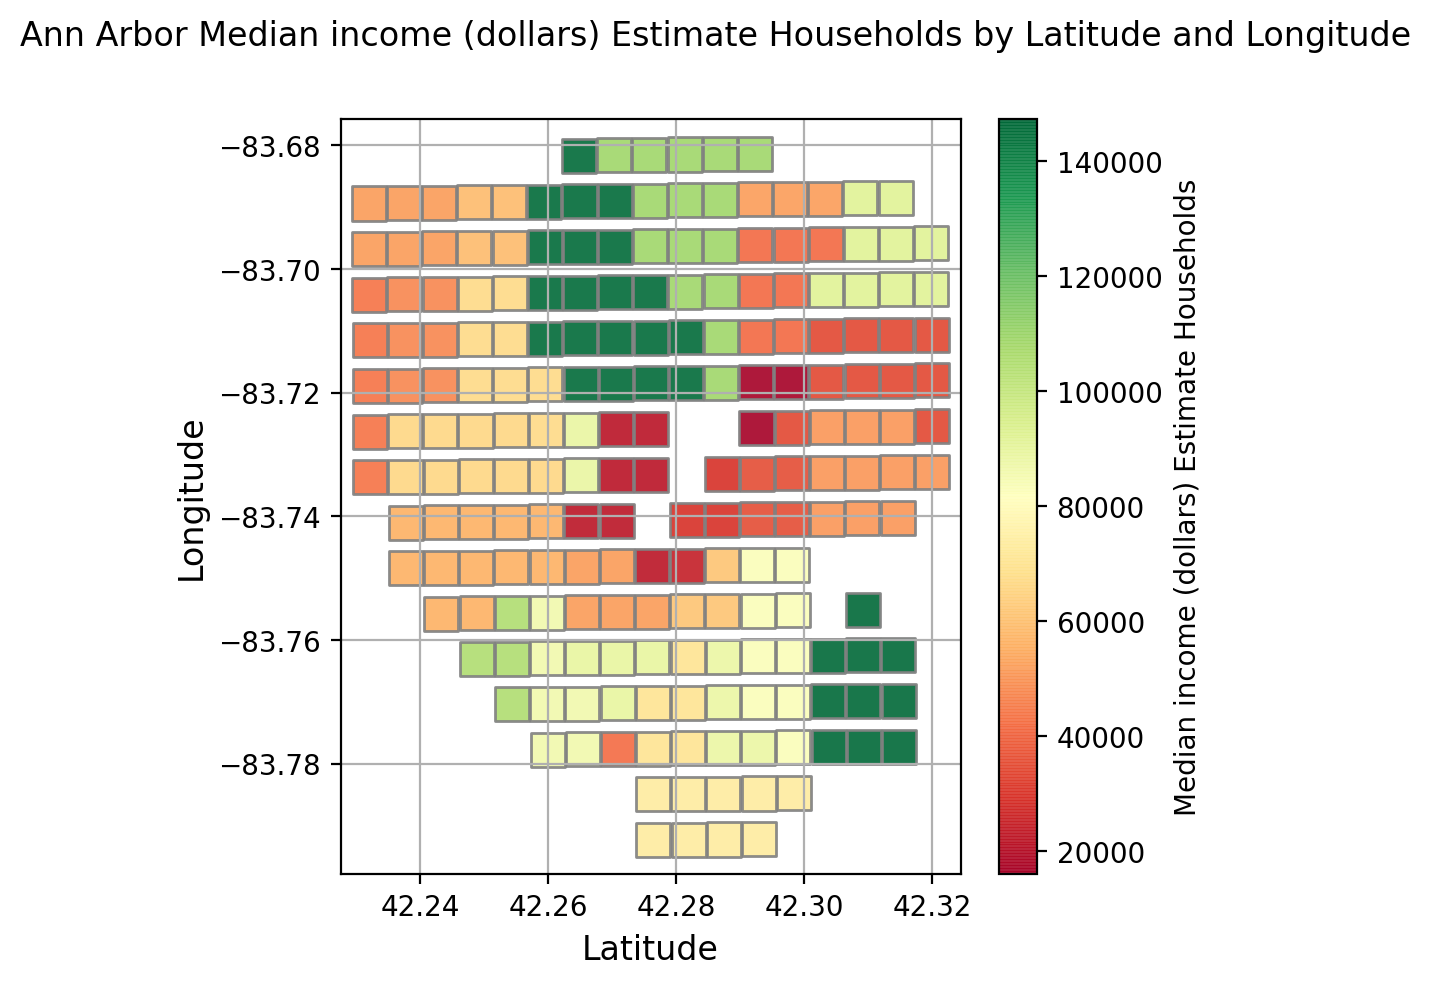

In [11]:
"""
median income by lat/lon
"""
tmp = pd.read_csv("../cleaned_data/income_column_map.csv")
INC_COLNAMES = dict(zip(tmp.GEO_ID, tmp.id))

TARGET_COL = 'S1903_C02_001E'
CLEAN_COL = INC_COLNAMES[TARGET_COL].replace("!!", " ")
TITLE = f'Ann Arbor {CLEAN_COL} by Latitude and Longitude'
MISSING_VALUE_DICT = {
    '(X)':np.nan,
    '-':np.nan,
    '**':np.nan}

tmp = data_df.copy()

tmp[TARGET_COL] = tmp[TARGET_COL].replace(MISSING_VALUE_DICT)
tmp = tmp[tmp[TARGET_COL].notna()]

fig = utils.build_fig(title=f"{TITLE}",
                      y_lab="Longitude", 
                      x_lab="Latitude")

scat = plt.scatter(tmp['latitiude'], 
                   tmp['longitude'], 
                   s=150, 
                   c=tmp[TARGET_COL],
                   edgecolor='grey',
                   alpha=0.9,
                   marker="s",
                   cmap='RdYlGn')

plt.grid()
cb = plt.colorbar(scat)
cb.set_label(f'{CLEAN_COL}')
save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')

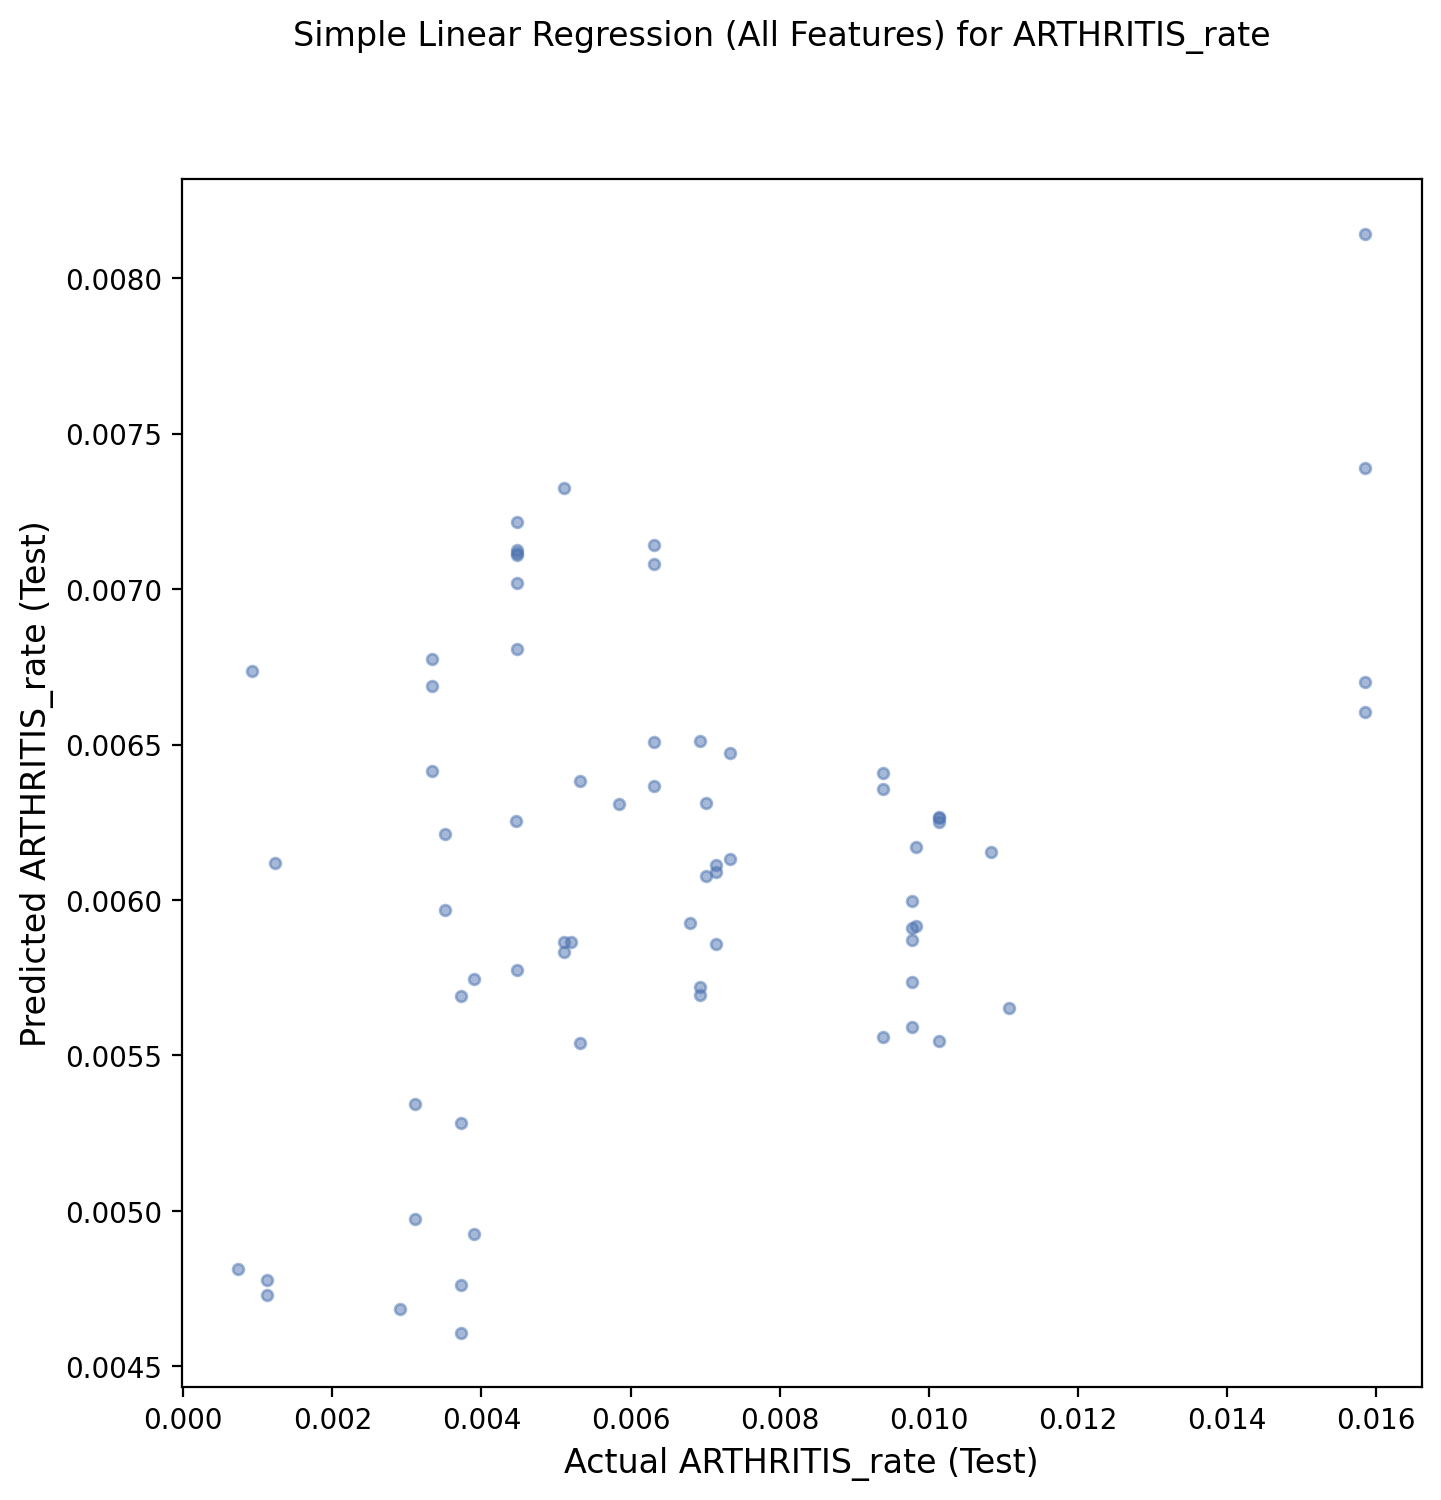

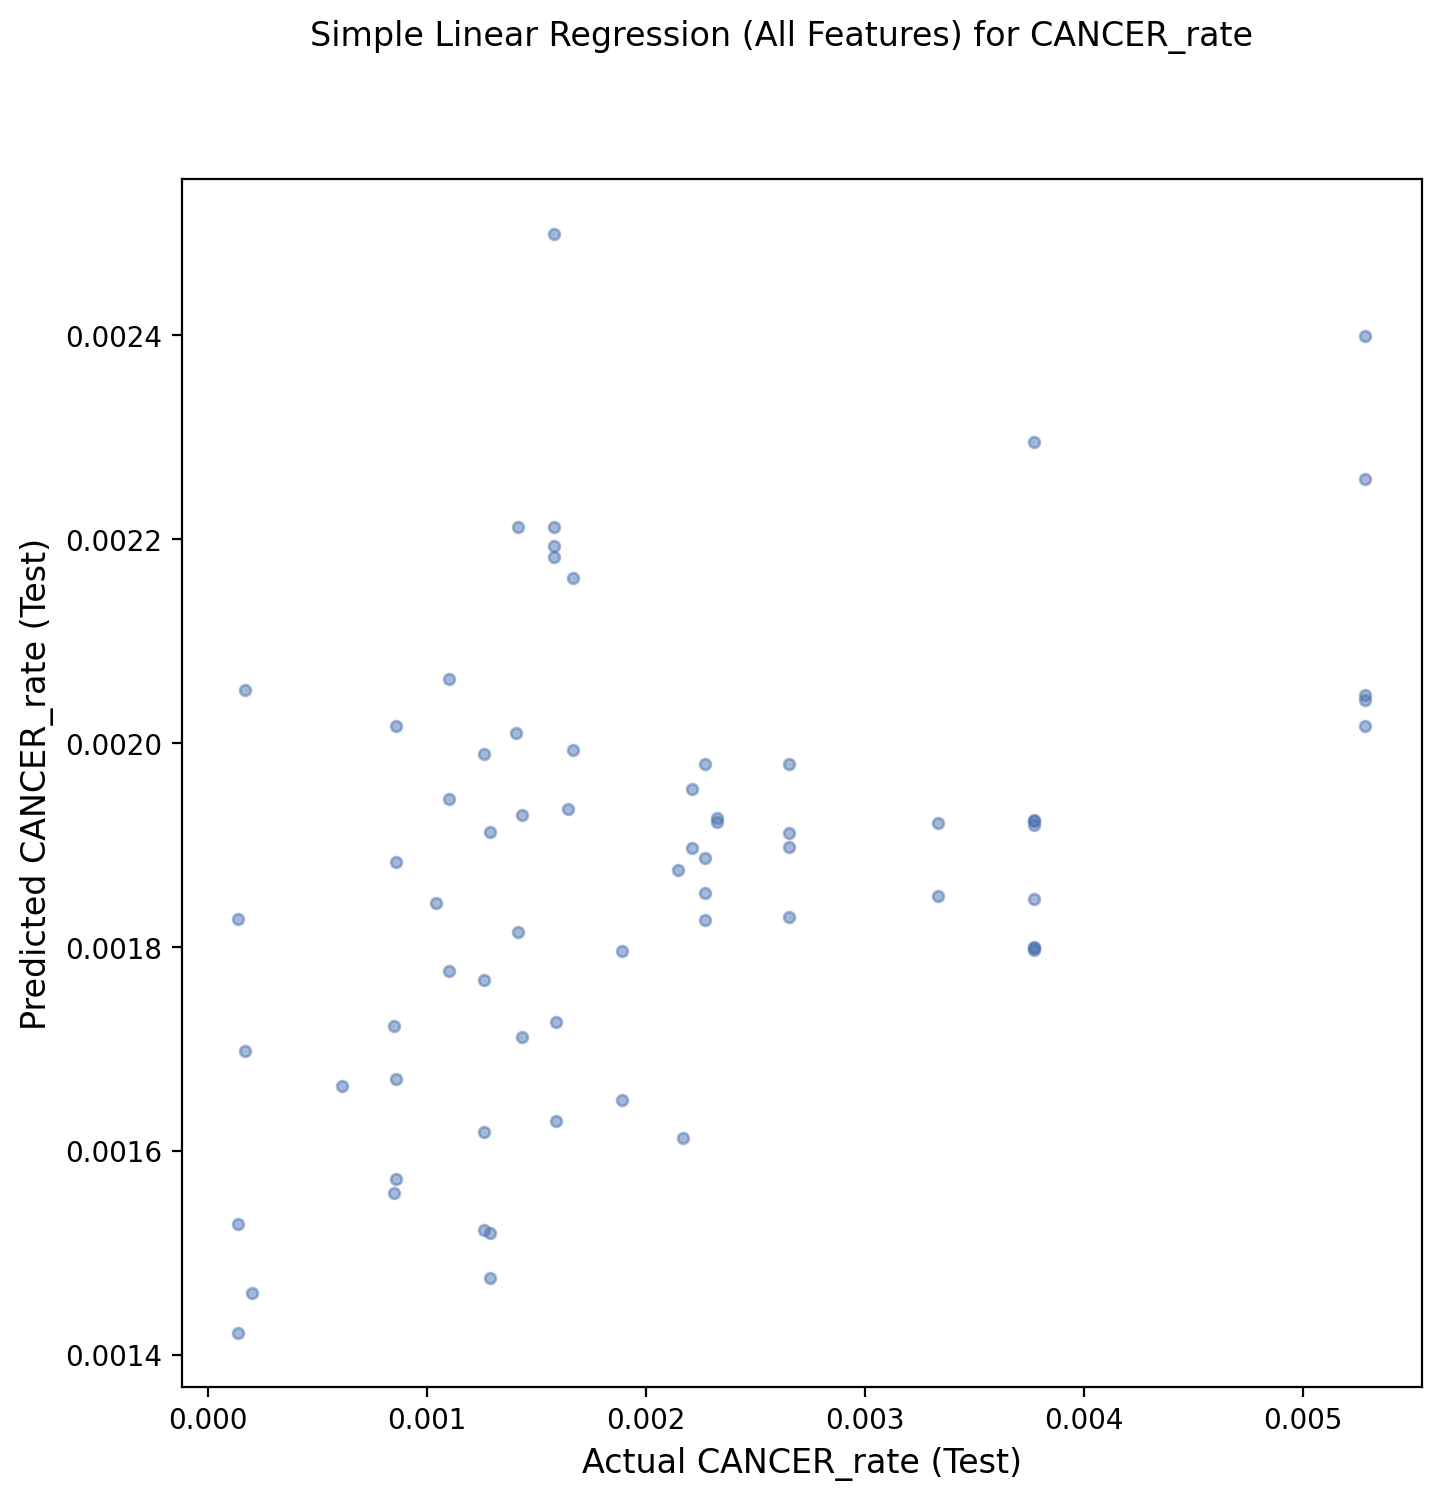

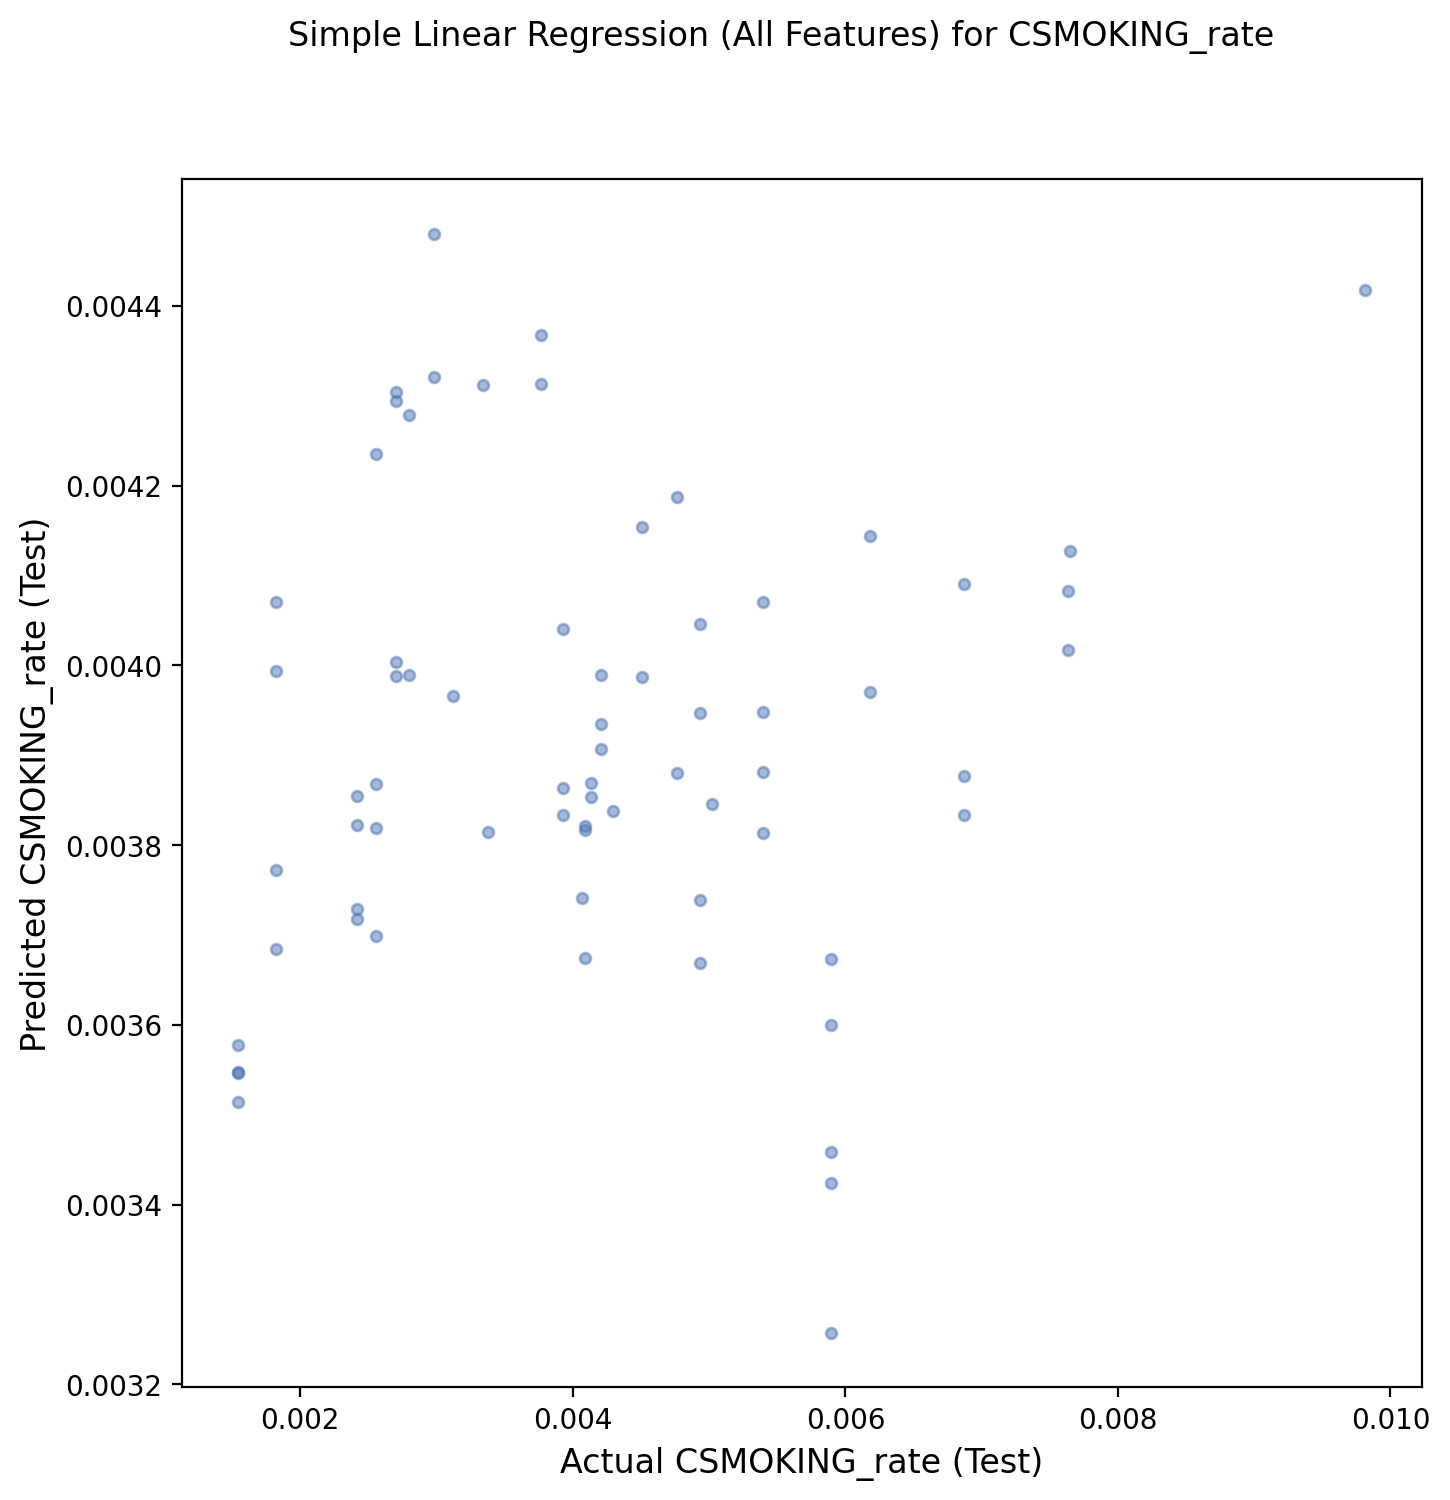

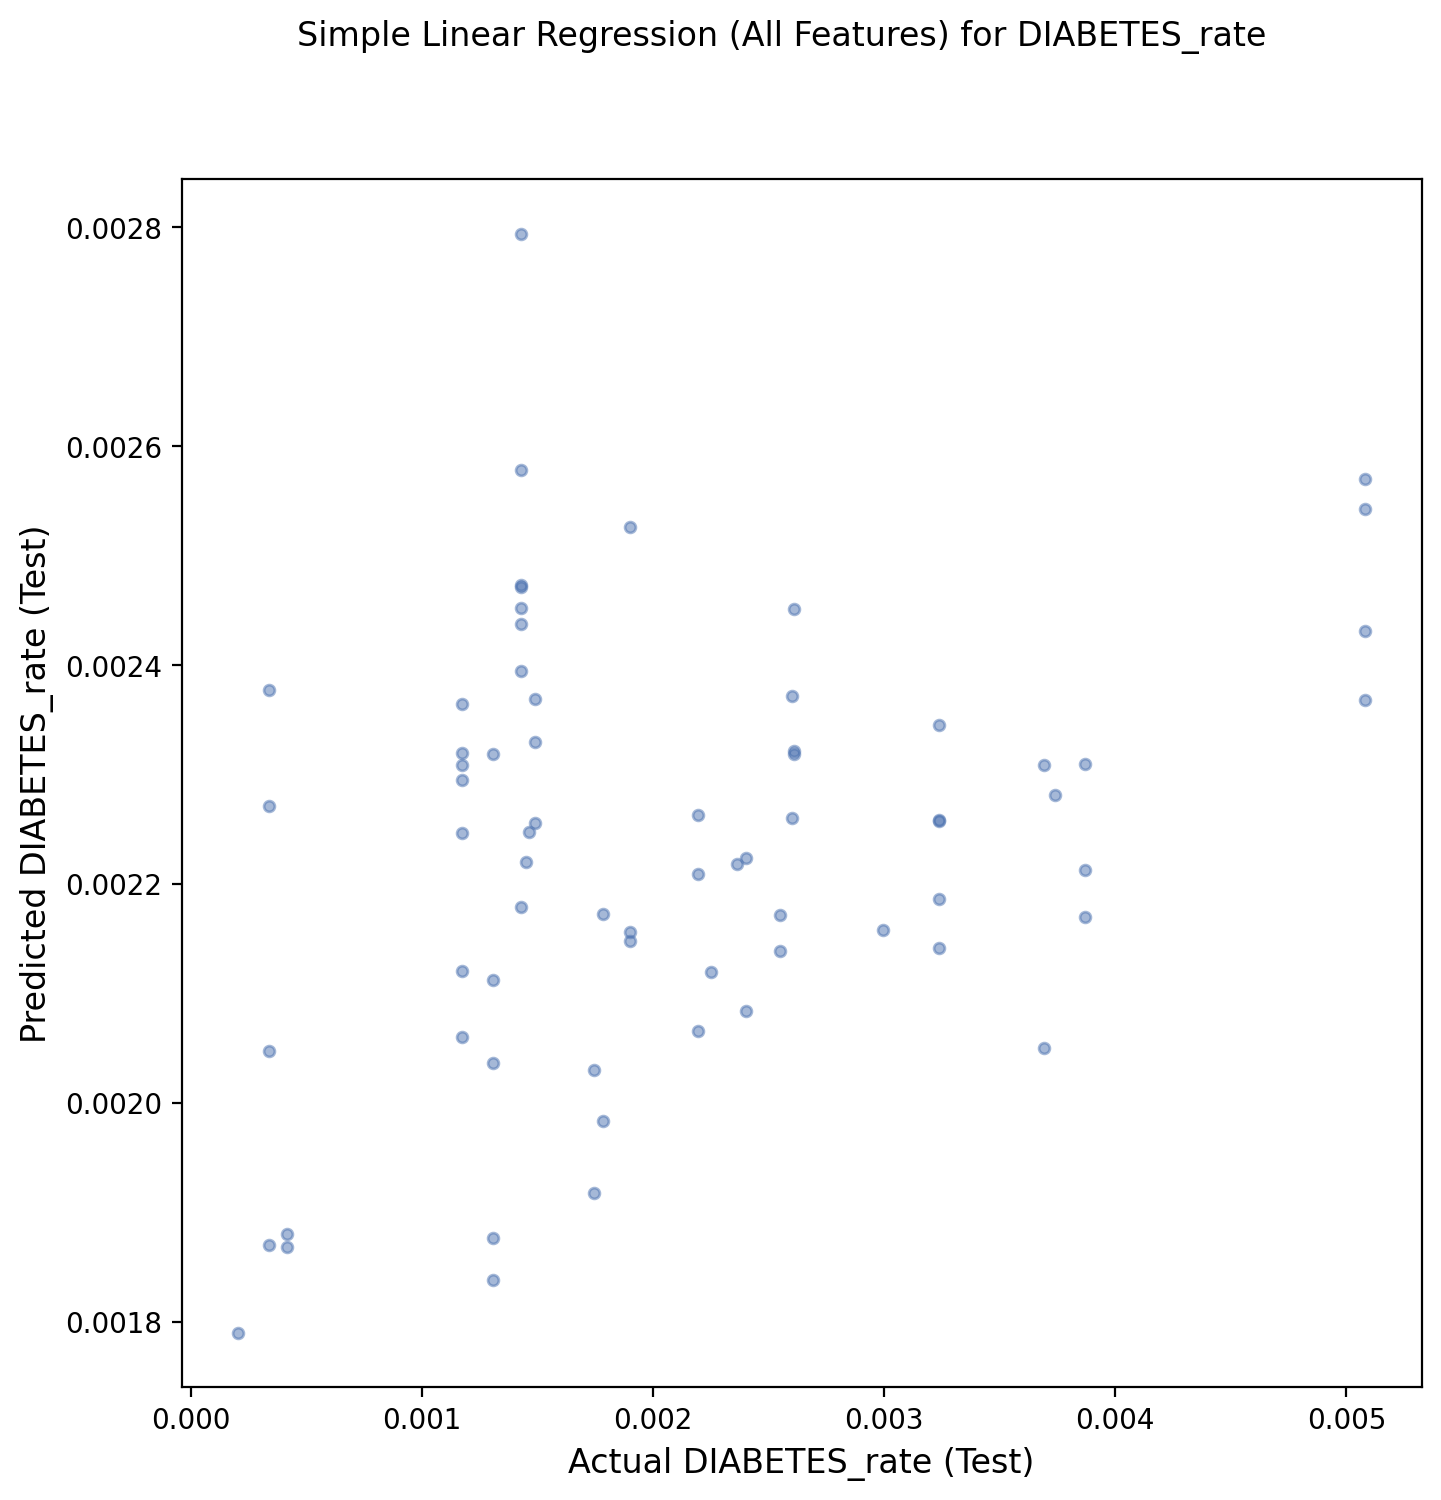

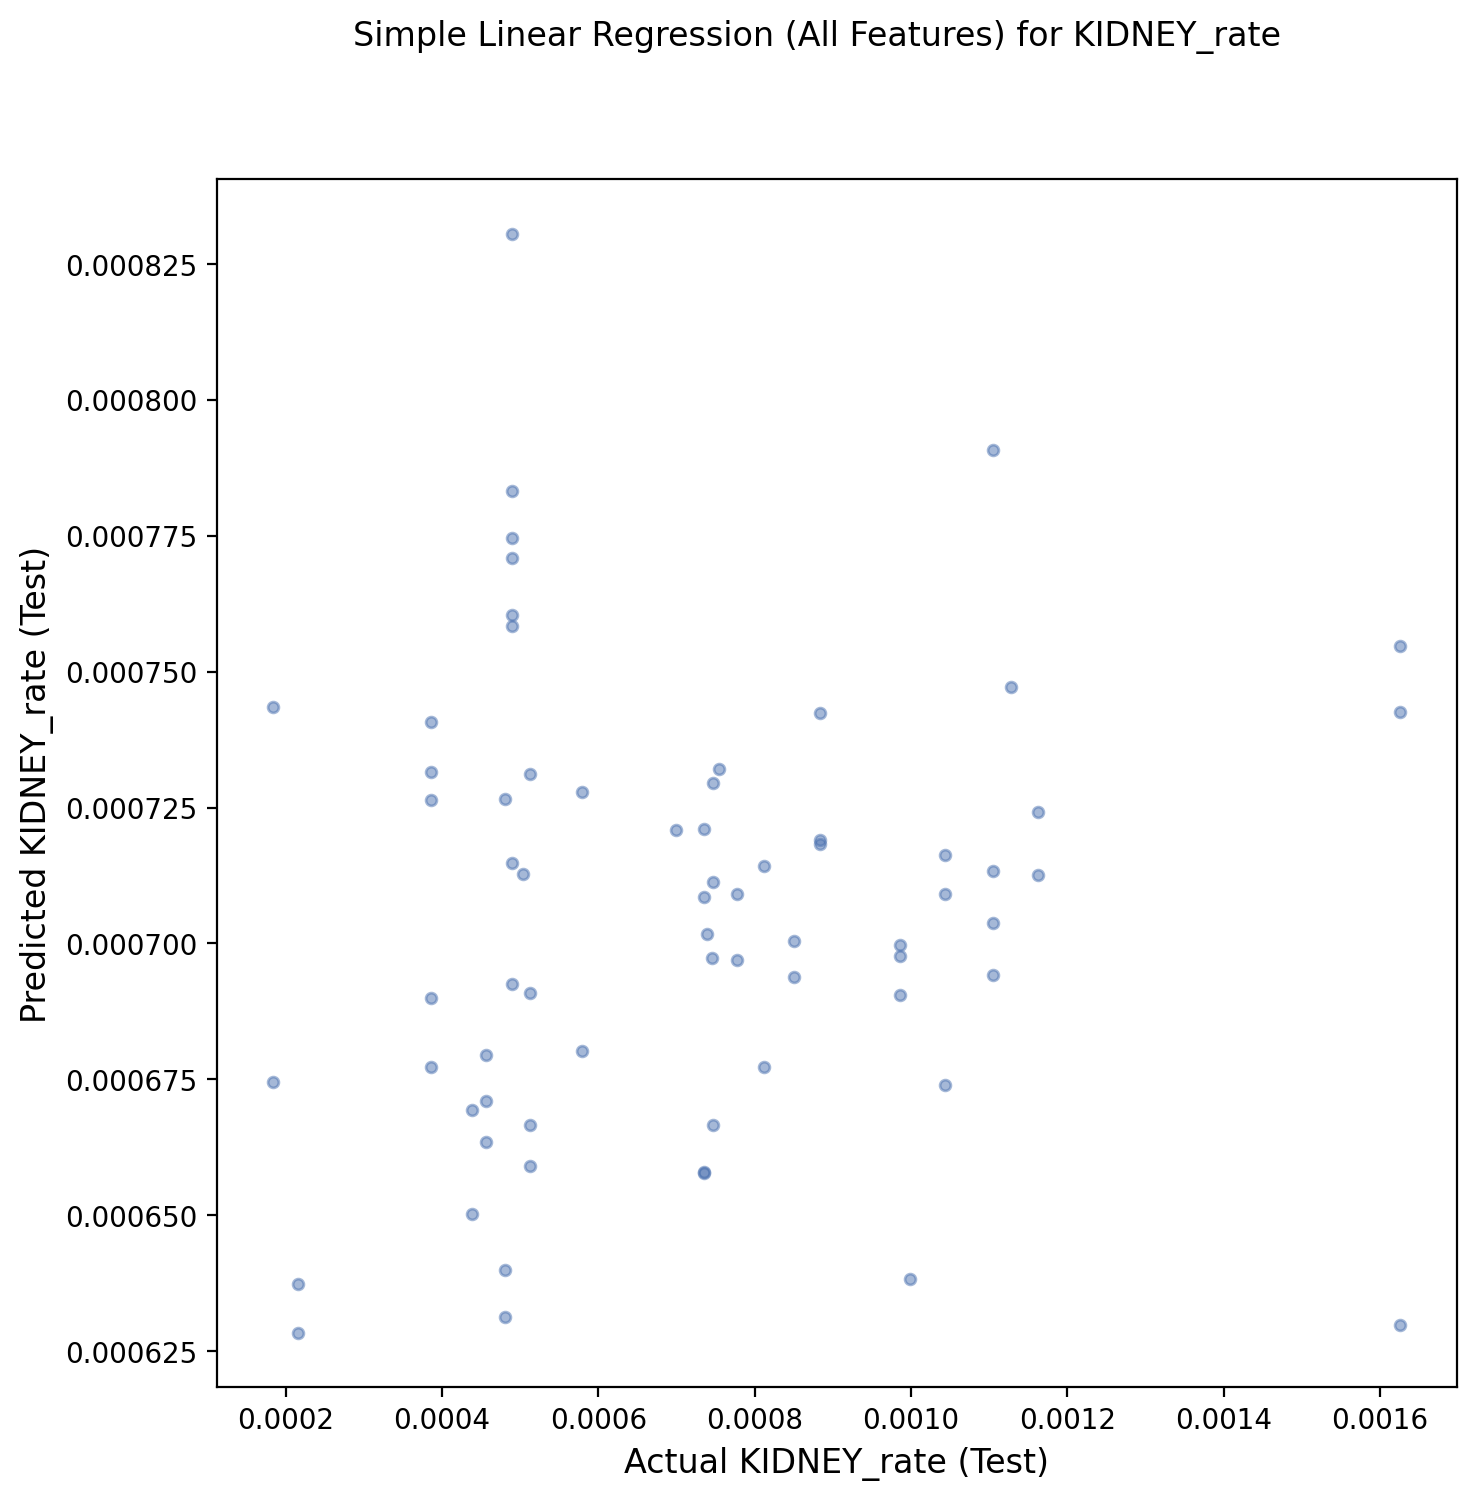

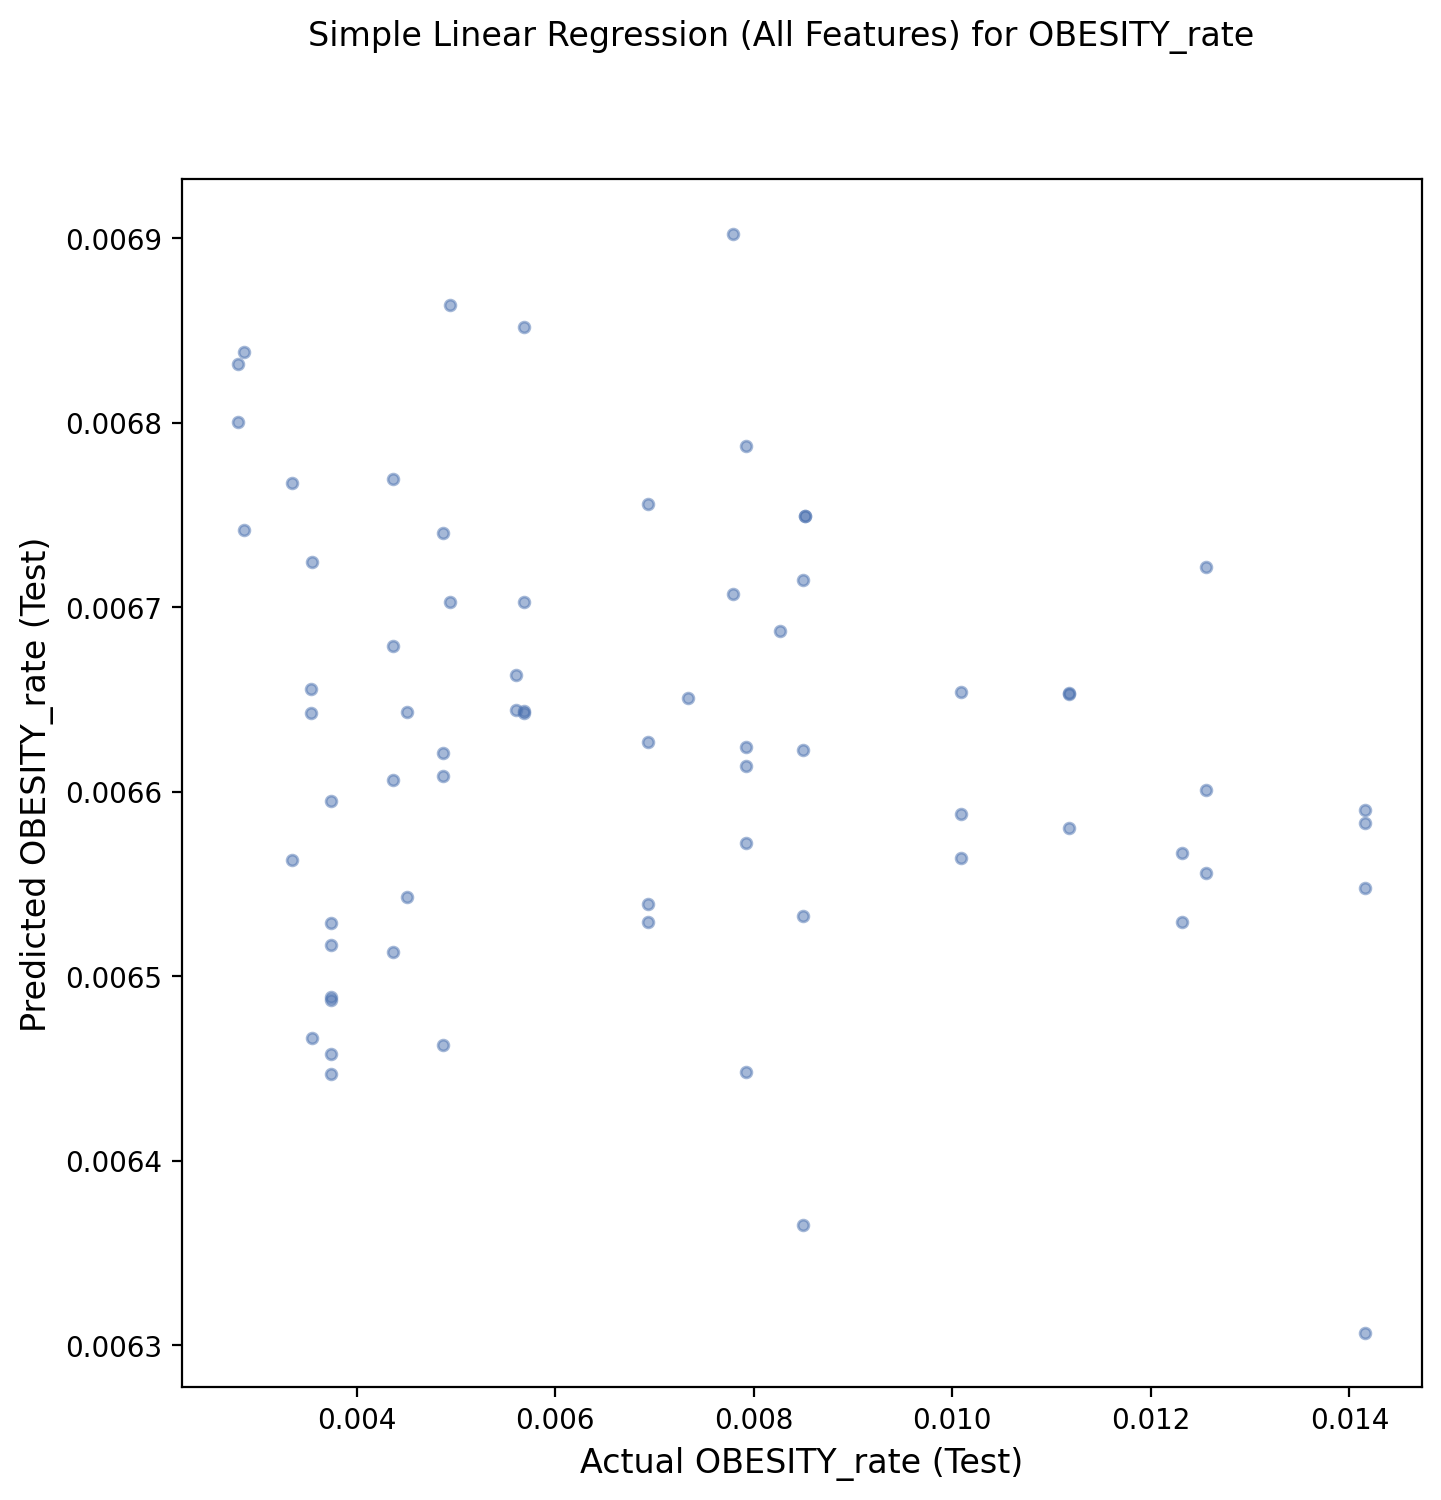

In [63]:
"""
do these images help us predict disease?
"""

FEATURES = REDS + BLUES + GREENS + GOOGLE_LABEL_COLS + GOOGLE_BLUE_COLS + GOOGLE_GREEN_COLS + GOOGLE_RED_COLS
CONDITIONS = ['ARTHRITIS_rate', 'CANCER_rate', 'CSMOKING_rate', 
              'DIABETES_rate', 'KIDNEY_rate', 'OBESITY_rate']


for target in CONDITIONS:
    TITLE = f"Simple Linear Regression (All Features) for {target}"
    tmp = data_df.copy()
    tmp = tmp[tmp[target].notnull()]

    tmp[FEATURES] = tmp[FEATURES].replace([np.inf, -np.inf], np.nan).fillna(-99999)

    X_train, X_test, y_train, y_test = train_test_split(tmp[FEATURES],
                                                        tmp[target], 
                                                        test_size=0.33)

    # clf = linear_model.LinearRegression(fit_intercept=False)
    clf = linear_model.ElasticNet(l1_ratio=0.8)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    fig = utils.build_fig(title=f"{TITLE}",
                        size = (8, 8),
                        y_lab=f"Predicted {target} (Test)", 
                        x_lab=f"Actual {target} (Test)")

    scat = plt.scatter(y_test, y_pred,
                s=15, 
                alpha=0.5)

    save_filepath = f"../figures/{TITLE}.png"
    plt.savefig(save_filepath,  bbox_inches = 'tight')
